In [35]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import network_funcs

COLOR = 'grey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

In [36]:
def odes_progen(x,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations

    Params:: 
        x: all network parameters
        t: time vector, not called in func but regardless (but used in odeint)
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function

    Returns:: Differential equations of each variable as a vector
    '''
    
    def checkGVs(x):
        numNodes, _ = x.shape
        for node in range(numNodes):
            if x[node,1]>1 or x[node,1]<0:
                print("ERROR_N: GATING VARS OUTSIDE OF RANGE")
                return 0
            if x[node,2]>1 or x[node,2]<0:
                print("ERROR_M: GATING VARS OUTSIDE OF RANGE")
                return 0
            if x[node,3]>1 or x[node,3]<0:
                print("ERROR_H: GATING VARS OUTSIDE OF RANGE")
                return 0
        return 1
    
    
    def checkV(x):
        numNodes, _ = x.shape
        for node in range(numNodes):
            if x[node,0]>100 or x[node,0]<-120:
                print("ERROR_V: GATING VARS OUTSIDE OF RANGE")
                return 0
        return 1
    
        
    def checkGeneral(x): 
        x = x.flatten().tolist()
        if any(y > 100 or y < -100 for y in x):
            print("ERROR: VALUE OUTSIDE OF ACCEPTABLE RANGE")
            return 0
        return 1
        
    ######### DEFINITIONS #########
    
    ### THIS IS MANUALLY SET AND MUST MATCH THE INPUT ###
    maxParams = 5 #Takes advantage of the fact that there will be a tau, v0, inf, etc. for each gating var
    #^ ie we can keep reusing this since there will be the same number of parameters necessary for each gating var
    #This is quasi-manual, based on the maxParams being 5... could probably make the equation itself automated?
    p = [1,20,-len(x)]
    roots = np.roots(p)
    numNodes = int(roots[1])

    numSC = numNodes-1 #calc_conx(numNodes)*2 <-- This is the total number of connections, but we only need to pass the max number of connections per node in for each node
    ES = [0] * numSC #ENa #mV #Excitatory Neuron (by this definition)
    
    #Convert list input into a matrix
    numParams = 1+4*maxParams+numSC #In this current form, there are 26 parameters per node.  I.e. 1 node is (1,26)
    x = np.reshape(x,(numNodes,numParams))
    
    status = 1
    ############################################################################################
    if (not checkGVs(x)) or (not checkGeneral(x)) or (not checkV(x)):
        print("ERROR")
        print(x)
        status = 0
    ############################################################################################
    
    if status:
        if len(x.shape)==1:
            #Ie if it is 1D, expand the dim to be (1,X) so that we can index as if it were 2D
            x = np.expand_dims(x,0)

        firstSIndex = numParams-numSC

        infs = np.zeros((numNodes,maxParams))
        taus = np.zeros((numNodes,maxParams))
        dxdts = np.zeros((numNodes,numParams)) #ONE FOR EACH VAR PASSED IN THROUGH Y0

        ######### CONSTANTS #########
        CmBase = 0.01 #uF
        #Altering the current for the nodes, essentially weighting them
        #In the test trials in NB 10, we used 1x for node1, and 0x for node2
        node_current = [0]*numNodes
        node_current[0] = 1
        if numNodes>1:
            #Do something more advanced later
            node_current[1] = 0
        node_current = np.array(node_current)*(1/CmBase)

        #For the synaptic coupling: 
        #^20 was a "good value" (ie one for which it functioned) in the previous NB
        gbars = [20] * numSC

        ######### LOOPING #########

        for nodeTemp in range(numNodes):  
            #Weighting matrix
            #WM = np.random.randint(low=998,high=1002,size=maxParams*4+1)/1000
            #Always breaks when doing it the above method
            WM = [1]*(maxParams*4+1)

            #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
            #reversal potentials
            ENa = 55.17*WM[0] #mV
            EK = -72.14*WM[1] #mV
            EL = -57.99*WM[2] #mV #-49.42
            #E4
            #E5
            #membrane capacitance
            Cm = CmBase*WM[5] #uF/cm^2

            #conductances (S is Siemens)
            gbarK = 0.36*WM[6] #mS/cm2
            gbarNa = 1.2*WM[7] #mS/cm2
            gbarL = 0.003*WM[8] #mS/cm2
            #So really there should be other values here for the 4th and 5th gating variables should those get used
            #gbar?(4) = ___
            #gbar?(5) = ___

            #For now, defining every neuron the same, but can change the "n,m,h" values...
            gK = (1/Cm)*gbarK*(x[nodeTemp,1]**4) #Why did I have a +maxParams after the 1?
            gNa = (1/Cm)*gbarNa*(x[nodeTemp,2]**3)*x[nodeTemp,3]
            gL = (1/Cm)*gbarL
            #Again, would need to add something for the 4th and 5th gating variables should they exist
            #...

            #Simplification: check connection in external function
            vnode_couplings = []
            svars = []   
            if numNodes==1:
                svars = [0]*numSC #1 neuron, so no connections.  Just return 0s
            else:
                SC_repo = network_funcs.check_SC(nodeTemp,numNodes) #RETURNS A DICTIONARY   

                if SC_repo is not None and len(SC_repo)>0:
                    for idx in range(numNodes):
                        idx = str(idx + 1) #Adjust for offset, first node is 1 not 0
                        if SC_repo.get(idx) is not None:
                            adj_idx = int(idx)-1
                            vnode_couplings.append(adj_idx) #This is the node that it is coupled to
                            sval = float(SC_repo.get(idx))
                            svars.append(sval) #This is the s val, to be used in gs

                    #Don't think this loop should actually ever run anymore
                    while len(svars)<numSC:
                        vnode_couplings.append(0)
                        svars.append(0)

                    my_zeros = [0]*(firstSIndex) #Ie a 1,21 vector of zeros, so once we add the 5 couplings to it, it meets 26
                    svars_full = my_zeros+svars
                    vnode_couplings_full = my_zeros+vnode_couplings
                else:
                    print("Error: SC_repo returned None")
            gs = np.array(gbars) * np.array(svars) #* (1/Cm)

            #Define the steady state (inf) values, and the time constants (tau)
            #Note that this must be completed first, so that all the taus, infs are defined before we can make the ODEs
            for param in range(maxParams):
                #inf(V, v0, sigma)
                infs[nodeTemp,param] = network_funcs.inf_func(x[nodeTemp,0], x[nodeTemp,param+(1+maxParams)], x[nodeTemp,param+(1+2*maxParams)])
                #tau(V, mean)
                taus[nodeTemp,param] = network_funcs.tau_func(x[nodeTemp,0], x[nodeTemp,param+(1+3*maxParams)])

            #Define each ODE    
            for param in range(numParams): 
                if param==0:
                    #dVdt = (gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + gs1*(ES1-Va) + ... + gsn*(ESn-Vz) + I(t,vI))

                    #TERM 1
                    ionChannels = gNa*(ENa-x[nodeTemp,0]) + gK*(EK-x[nodeTemp,0]) + gL*(EL-x[nodeTemp,0])
                    #Would need to include the 4th and 5th gating variables somehow...
                    #How to make this automatic instead of manual...

                    #TERM 2
                    synCoups = 0
                    for idx in range(numSC):
                        #Replaced vnode_couplings[idx]-1 with idx
                        synCoups += gs[idx]*(ES[idx]-x[nodeTemp,0])
                        #^ Terms: (conducance gs_x) * (ES - V)

                    #TERM 3
                    appliedCurrent = network_funcs.I(t,vI)*node_current[nodeTemp]

                    dxdts[nodeTemp,param] = ionChannels + synCoups + appliedCurrent
                elif param<(maxParams+1): #ie the gating variables
                    #Note we use [nodeTemp,param-1] because there is no tau/inf for V so the matrix tau starts with n @ index 0
                    dxdts[nodeTemp,param] = network_funcs.diffEQ_func(taus[nodeTemp,param-1], infs[nodeTemp,param-1], x[nodeTemp,param]) 
                elif param>=firstSIndex and sum(svars_full)==0: #ie if all the s vars are equal to zero
                    break #ie just leave them as zero, and we are done with the loop so we can just break
                elif param>=firstSIndex:
                    #STILL MANUAL
                    tau_s = 30 #ms
                    s_inf = 10.0/11.0 
                    beta_s = 1/tau_s

                    if numNodes==1:
                        pass #ie dsdts remain zeros
                    else:
                        s = svars_full[param]
                        if s==0:
                            #Not sure if this will ever happen
                            #Goal is to get around cases where no s is passed in so s is 0
                            #^Maybe initilize that array to something biophysically impossible (e.g. can s be neagtive?)
                            dxdts[nodeTemp,param] = 0 
                        else:
                            coupled_neuron = vnode_couplings_full[param]
                            #coupled_neuron-1 because Neuron 1 corresponds to row 0
                            alpha_s = (x[coupled_neuron-1,0]>0)*(1/tau_s)

                            dxdts[nodeTemp,param] = alpha_s*(1-s)-beta_s*s 

                    #This should be the last case, it will run once the way it currently configured
                    #break
                else:
                    pass
                    #Should just be equal to zero, so leave as is (matrix is initialized as zeros)

        #Rearrange dxdts into a list so that we can unpack it
        flat_array = dxdts.flatten()
        ODE_list = flat_array.tolist()

        return ODE_list
    else:
        print("-------------------------------------------------------------")
        return np.zeros((numNodes,numParams)).flatten().tolist()

In [37]:
#Things that don't need to be assigned every time
t = np.linspace(0,50,2000) #time vector
vI = [0,0,0] #vector needed to control the current
V1 = -58.0; n1 = 0.05; m1 = 0.33; h1 = 0.6 #Voltage and gating var ICs
#V0: Manipulates the x location placement
V0n1 = -49.0; V0m1 = -36.0; V0h1 = -55.0
#Sigma: Manipulates the steepness, bigger sigma means less steep step
sigman1 = 18.0; sigmam1 = 10.0; sigmah1 = -8.0
#Tau's
tau_n_mean1 = 2.785; tau_m_mean1 = 0.258; tau_h_mean1 = 2.810
node1Base = [V1, n1, m1, h1, 0, 0, 
         V0n1, V0m1, V0h1, 0, 0, 
         sigman1, sigmam1, sigmah1, 0, 0, 
         tau_n_mean1, tau_m_mean1, tau_h_mean1, 0, 0]

Burn in run, looking for NO oscillations


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


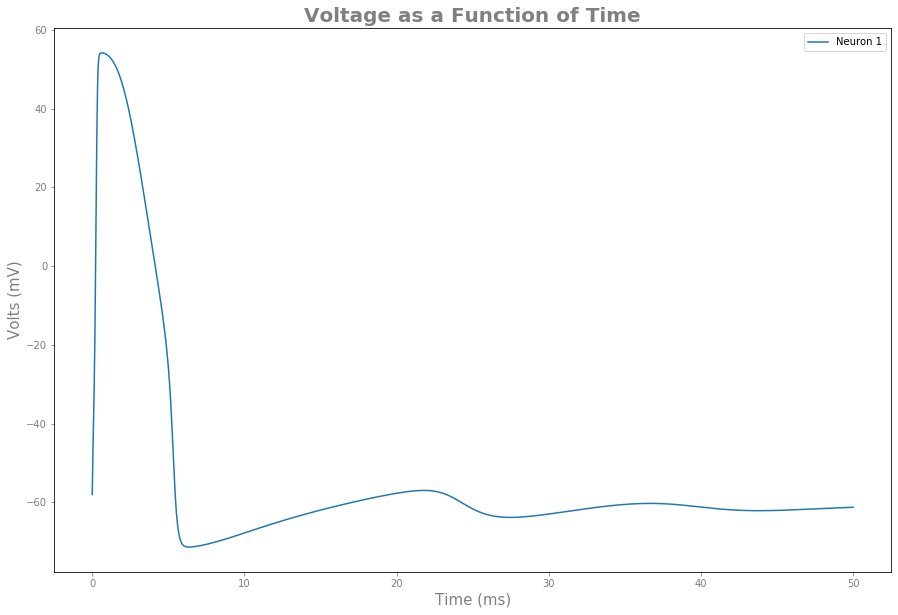

Burn in complete
Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected


C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: divide by zero encountered in double_scalars
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))
C:\Users\14193\Desktop\Summer2021\Brown\hh-comp\network_funcs.py:143: RuntimeWarning: overflow encountered in exp
  x_inf = 1 / (1 + np.exp(-(V-v0)/sigma))


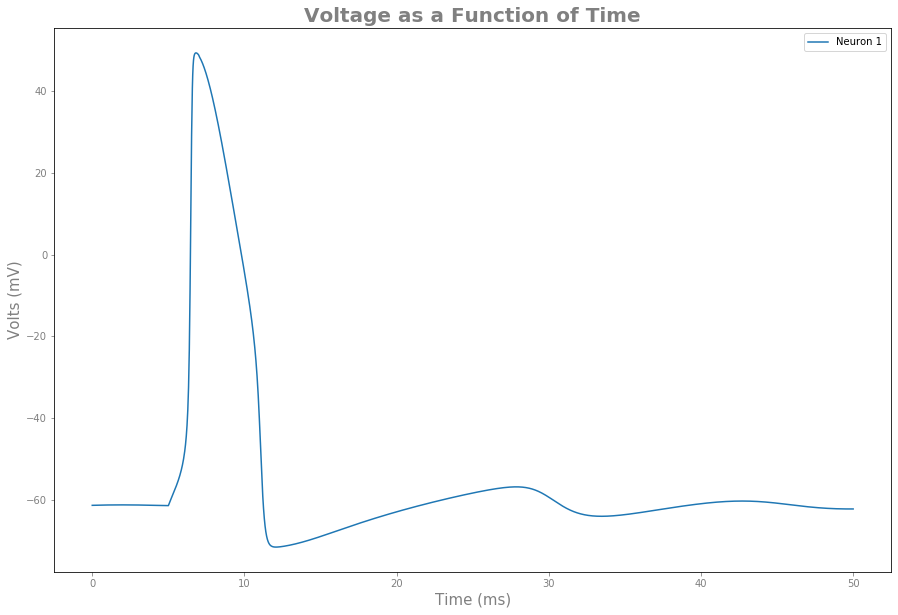

In [38]:
print("Burn in run, looking for NO oscillations")
numNodes = 1 #NEED TO SET THIS
#####################################################################################
node1 = node1Base + ([0]*(numNodes-1))
network_params = node1*numNodes #Letting all nodes be the same
x = odeint(odes_progen,network_params,t,args=(network_funcs.I,vI))
x = np.transpose(x)
network_funcs.plot_vnmh(x,t,numNodes)
#Now grab the burned in values from the previous run
network_params_BI = x[:,-1]
print("Burn in complete")
print("Actual run, using a current of 0.1 A @ 5 ms.  Oscillations expected")
#BURNED IN initial condition
vI = [5,7,0.1]
x = odeint(odes_progen,network_params_BI,t,args=(network_funcs.I,vI))
x = np.transpose(x)
network_funcs.plot_vnmh(x,t,numNodes)

0.33